# Yelp Restaurant Rating Prediction

## Project Description
The project goal is to predict restaurant overall ratings on yelp
in New York City, using multiple features of restaurants that we will
extract using the yelp API. Our motivation is to help determine how
successful a new restaurant business might be, given certain known
characteristics of it.

We will use the Yelp API, with the help of pandas, to acquire raw data
from restaurants. Then we will extract reasonable features such as
location, open hours, whether it takes reservations, whether it has
delivery service, whether there is parking space, and whether it
provides free wifi etc., from the parsed data, and combine with the
overall ratings, which is a numerical value ranging from 0 to 5, as
labels.

We will model the rating distribution over the different features that
we extract and create, and analyse how much each feature shifts our
distribution. Using our results from this we will select good features
to train on machine learning models.

Using the labeled features that we construct, we will train different
machine learning models like linear regression, nonlinear regression,
logistic regression as well as neural networks, then make some
predictions, and compare the accuracy obtained from them.

## Team Members
Jun Hee Kim, Nikhil Rangarajan, Sander Shi

## Procedure
* [Data Gathering from API](#step-1)
* [Feature Extraction with Parsing](#step-2)
* [Feature Analysis and Variable Selection](#step-3)
* [Setup of Models](#step-4)
* [Cross Validation](#step-5)
* [Final Analysis](#step-6)

## Part 0: Imports and Definitions of Constants

We will be using `pandas` to parse the data and `tensorflow` to construct the machine learning models. We will also be using the Yelp API to gather the data. In order to
use the Yelp API, we need to create an API key to use in our API requests.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import requests
import json
import time
import pickle
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as stats

API_URL = "https://api.yelp.com/v3/businesses"
SEARCH_URL = API_URL + "/search"
RESTAURANT_IDS = "rid.pkl"

with open("./API_KEY", 'r') as f:
    api_key = f.readline().strip()
API_HEADERS = {
    'Authorization': ' '.join(['Bearer', api_key])
}

<a id="step-1"></a>

## Part 1: Data Gathering from API

In this step we will use the Yelp API to gather restaurant pages, then extract
information using business search API requests.

Since the Yelp API will only allow us to load business information from up to 1000
distinct businesses on each search, we will first get the categories of the
restaurants, then perform a search query for each category.

In [2]:
def get_restaurant_categories(url):
    """
    This function gets all restaurant categories.
    
    @input url: URL to json file containing restaurant categories.
    @type url: String.
    
    @return: List of restaurant categories.
    @rtype: List of String
    """
    cats = json.load(open(url))
    return [cat['alias'] for cat in cats if 'restaurants' in cat['parents']]

categories = get_restaurant_categories('categories.json')

Now that we have the restaurant categories, we can write a function to find all
restaurant IDs, and create a Pandas DataFrame. To aid debugging, we will dump
the dataframe into a pickle file so that we will not have to regenerate each time.

In [3]:
def get_req_json(url, params=None):
    """
    This function is a wrapper for a get request to the API.
    
    @input url: The API url.
    @type url: String.
    @input params: The parameters to pass to the get request.
    @type params: Dict.
    
    @return: A json response.
    @rtype: JSON
    """
    response = requests.get(url=url, headers=API_HEADERS, params=params)
    return response.json()


def find_restaurants(url, categories):
    """
    This function loads all restaurant data from restaurants in NYC.
    
    @input url: The API url.
    @type url: String.
    @input categories: The restaurant categories.
    @type categories: List of String.
    
    @return: A Pandas DataFrame containing the restaurant IDs.
    @rtype: pandas.DataFrame.
    """
    restaurants = []
    for cat in categories:
        params = {
            'term': 'restaurants',
            'location': 'NYC',
            'categories': cat
        }
        content = get_req_json(url, params)
        total = min(1000, content['total'])
        i = 0
        while i < total:
            limit = min(50, total - i)
            params['limit'] = limit
            params['offset'] = i
            content = get_req_json(url, params)
            restaurants.extend([b['id'] for b in content['businesses']])
            i += limit
    return pd.DataFrame({'id': list(set(restaurants))})

# Uncomment the following lines to get the restaurant IDs and recreate the pickle file.
# restaurants = find_restaurants(SEARCH_URL, categories)
# pickle.dump(restaurants, open(RESTAURANT_IDS, "wb"))

# Load restaurant IDs from pickle file
restaurant_ids = pickle.load(open(RESTAURANT_IDS, 'rb'))
restaurant_ids

,id
0,UTNSUIY2QW6RYNa0xLa9gg
1,h5WkewI6U7NjLB_n6WgdvQ
2,yOPbrFZ2ZUsyQWsedP6gUg
3,2ngodDyMj6M0szyBbGSJ5g
4,8ghGdEWOkGWUNeGrtdiaDQ
5,58v6bJy_vQLMWxLSMZHvYA
6,4LoroCI3VtQ17dyQa75-Rg
7,1_JZHKkWQBozYQ00fephWQ
8,YRfDdBgWS4T80oJfKmVThA
9,IUMTe7g19htqG7MXrsP5NQ


<a id="step-2"></a>

## Part 2: Feature Extraction with Parsing

Now that we have all the restaurant ids, in this step we can do a business lookup
to get the features from the restaurants.

In [4]:
def get_features(rids, api_url):
    """
    This function creates a dataframe of features given restaurant IDs.
    
    @input api_url: The API url.
    @type api_url: String.
    @input rids: The dataframe containing all restaurant IDs.
    @type rids: pandas.DataFrame.
    
    @return: A Pandas DataFrame containing the restaurant URLs.
    @rtype: pandas.DataFrame.
    """
    prices, ratings, pickups, deliveries= [], [], [], []
    reservations, is_claimed, zipcodes = [], [], []
    days = [2, 4, 5, 6]
    hours = dict()
    for day in days:
        hours[day] = []
    for idx, rid in rids.iterrows():
        # Get Request
        url = "/".join([api_url, rid['id']])
        content = get_req_json(url)
        
        # Extract Features
        prices.append(len(content.get('price', "")))
        ratings.append(float(content.get('rating', 0)))
        transactions = content.get('transactions', [])
        pickups.append(int("pickup" in transactions))
        deliveries.append(int("delivery" in transactions))
        reservations.append(int("restaurant_reservation" in transactions))
        is_claimed.append(int(content.get('is_claimed', False)))
        if ('location' not in content) or ('zip_code' not in content['location']):
            zipcodes.append('0')
        else:
            zipcodes.append(content['location']['zip_code'])
        for day in [2, 4, 5, 6]:
            if "hours" in content:
                open_hours = content["hours"][0]["open"]
                stats = [h for h in open_hours if h['day'] == day]
                is_overnight = int(True in [h['is_overnight'] for h in stats])
                start = min([h['start'] for h in stats], default='0000')
                end = max([h['end'] if h['end'] != '0000' else '2400' for h in stats], default='0000')
                hours[day].append([is_overnight, start, end])
            else:
                hours[day].append([0, '1200', '1800'])

        # TODO: Figure out which category to take
        categories = [c['alias'] for c in content['categories'] if 'categories' in content]
    for day in days:
        hours[day] = np.array(hours[day])
    df_dict = {
        'price': prices,
        'pickup': pickups,
        'delivery': deliveries,
        'restaurant_reservation': reservations,
        'is_claimed': is_claimed,
        'zip_code': zipcodes,
        'rating': ratings,
        'wed_is_overnight': hours[2][:, 0].astype(int),
        'fri_is_overnight': hours[4][:, 0].astype(int),
        'sat_is_overnight': hours[5][:, 0].astype(int),
        'sun_is_overnight': hours[6][:, 0].astype(int),
        'wed_start': hours[2][:, 1],
        'fri_start': hours[4][:, 1],
        'sat_start': hours[5][:, 1],
        'sun_start': hours[6][:, 1],
        'wed_end': hours[2][:, 2],
        'fri_end': hours[4][:, 2],
        'sat_end': hours[5][:, 2],
        'sun_end': hours[6][:, 2]
    }
    return pd.DataFrame(df_dict)


# Uncomment the following lines to get the features and dump to a pickle file.
# labeled_features = get_features(restaurant_ids, API_URL)
# pickle.dump(labeled_features, open("features.pkl", "wb"))

# Load labeled features from pickle file
labeled_features = pickle.load(open("features.pkl", 'rb'))
labeled_features

,delivery,fri_end,fri_is_overnight,fri_start,is_claimed,pickup,price,rating,restaurant_reservation,sat_end,sat_is_overnight,sat_start,sun_end,sun_is_overnight,sun_start,wed_end,wed_is_overnight,wed_start,zip_code
0,1,1445,0,1100,1,1,0,2.5,0,0300,1,2030,0200,1,1100,0200,1,1100,11230
1,1,0400,1,1600,1,1,2,4.0,1,0400,1,1100,2400,0,1100,0200,1,1600,10016
2,1,0300,1,1200,1,1,2,3.5,0,0300,1,1100,0200,1,1100,0200,1,1200,10025
3,1,2200,0,1200,0,1,1,3.0,0,2200,0,1200,2200,0,1200,2200,0,1200,11105
4,1,2000,0,0800,1,1,2,4.5,0,2000,0,0900,1800,0,0900,1900,0,0800,11231
5,0,0200,1,1700,0,0,2,2.0,0,0200,1,1700,0200,1,1700,0200,1,1700,10028
6,1,0200,1,1600,1,1,2,4.0,1,0200,1,1600,0100,1,1130,0100,1,1600,10014
7,0,1800,0,0800,1,0,0,5.0,0,1800,0,0800,1800,0,0800,1800,0,0800,11232
8,1,0300,1,1100,1,1,2,3.0,0,0300,1,1100,2200,0,1100,2300,0,1100,10026
9,1,2330,0,1100,1,1,2,3.5,0,2330,0,1100,2330,0,1100,2330,0,1100,10022


<a id="step-3"></a>

## Part 3: Feature Analysis and Variable Selection

Now that we have the features, we can separately analyse them and see how each feature
contributes to the rating.

### 1) Price
There are four levels (1, 2, 3, or 4) in price. Let's plot the frequency distribution of ratings for each price level to see if they differ alot, and then run an one-way ANOVA test to see if the population means of the ratings are different for at least two price levels.

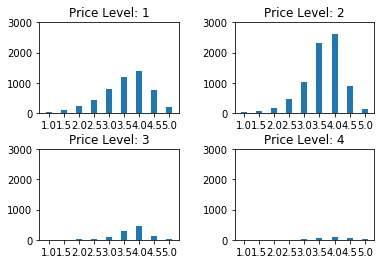

In [5]:
# Bar chart of ratings for each of the 4 levels of price
def barplot_each_price(price_levels, rating, df):
    """
    Input: 
    - price_levels is the list of possible price levels
    - rating is the list of possible ratings
    - df is the pandas dataframe containing the data
    
    This function plots the bar chart of the ratings for each of the price levels
    """
    for i in price_levels:
        price = i
        # ratings with this price level
        this_price_df = df.loc[df['price']==price]
        data = this_price_df['rating']
        counter = Counter(data)
        #rating = np.linspace(1, 5, 9)
        freq = [counter[rate] for rate in rating]
        plt.subplot(2,2,i)
        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.bar(rating, freq, width=0.2)
        plt.ylim(ymin=0, ymax=3000)
        plt.xticks(rating, rating)
        plt.title("Price Level: %s"%price)

barplot_each_price(price_levels=[1,2,3,4], rating=np.linspace(1, 5, 9), df=labeled_features)

We've set the y-axis range to be the same for all four subplots so that visually comparing becomes easier. We can clearly see that the frequency is not similar across all price levels: especially the two lower price levels' rating frequencies appear very different from the two higher levels. Let's perform ANOVA to yield some formal conclusion.

In [6]:
# One-way ANOVA on price levels

def price_oneway_ANOVA(price_levels, df):
    '''
    Input: 
    - price_levels is the list of possible price levels
    - df is the pandas dataframe containing the data
    
    This function returns the output of one-way ANOVA on ratings across different price levels
    '''
    # This dictionary will have each key being each price level, and the corresponding value will be the array
    # of the ratings of the restaurants with that price level
    price_rating_dict = dict()
    for price in price_levels:
        this_price_df = df.loc[df['price']==price]
        price_rating_dict[price] = np.array(this_price_df["rating"])
    return stats.f_oneway(*price_rating_dict.values())

price_oneway_ANOVA(price_levels=[1,2,3,4], df=labeled_features)

F_onewayResult(statistic=47.881875028686295, pvalue=8.858077827347636e-31)

According to the ANOVA output, at $\alpha=0.05$ (or even $\alpha=0.01$), the p-value is less than $\alpha$, so at least two price levels have population rating means that are different. A limitation of one-way ANOVA is that we can't conclude which groups have different population rating means, but in our context, knowing that the rating means differ in at least two levels lets us conclude price is an important feature.

### 2) Transactions (Pickup, Delivery, Reservation)

We've parsed the transaction features as: "pickup" is 1 if pickup is available in that restaurant and 0 otherwise, and similarly for "delivery" and "restaurant_reservation". For each of the three transaction features, let's use two-sample t-test (one group of the restaurants that have that transaction, and the other group of those that don't) to determine if the two groups have differnt population rating means.

In [8]:
def two_sample_ttest(feature_name, values, df):
    """
    Input: 
    - feature_name is the name of the feature
    - values is the list of 2 possible values (which determine the 2 groups)
    - df is the pandas dataframe containing the data
    
    This function returns the output of one-way ANOVA on ratings across different price levels
    """
    feature_rating_dict = dict()
    for value in values:
        this_value_df = df.loc[df[feature_name]==value]
        feature_rating_dict[value] = np.array(this_value_df["rating"])
    return stats.ttest_ind(*feature_rating_dict.values(), equal_var=False)

transaction_vars = ["pickup", "delivery", "restaurant_reservation"]
for feature in transaction_vars:
    print(feature, ":", two_sample_ttest(feature_name=feature, values=[0,1], df=labeled_features))

pickup : Ttest_indResult(statistic=3.725501822879328, pvalue=0.00019559544727886272)
delivery : Ttest_indResult(statistic=5.937444695147774, pvalue=2.954586761552284e-09)
restaurant_reservation : Ttest_indResult(statistic=-14.785163939519565, pvalue=1.8195535645110063e-47)


According to the t-test output, for each of the three transaction features, at $\alpha=0.05$ (or even $\alpha=0.01$), the p-value is less than $\alpha$ so the two groups have population rating means that are different. One might think that all three features should be included in the model.

But common sense makes us suspicious about correlations among the transaction features, and in general, correlated features can cause problems in modeling (e.g. multicollinearity problem in linear regression). Let's examine the correlation coefficient for each pair among the three.

In [10]:
def print_pcc(list_vars, df):
    """
    Input
    - list_vars is the list of feature names in which the Pearson Correlation Coefficient for each pair is computed
    - df is the pandas dataframe containing the data
    
    This function prints the Pearson Correlation Coefficient for each pair of the features provided in the list
    """
    for i in range(0, len(list_vars)):
        for j in range(i+1, len(list_vars)):
            corr = np.corrcoef(df[list_vars[i]], df[list_vars[j]])[0,1]
            print(list_vars[i],  ",", list_vars[j], corr)

print_pcc(transaction_vars, df=labeled_features)

pickup , delivery 0.9299431408739303
pickup , restaurant_reservation 0.1124913276590197
delivery , restaurant_reservation 0.09569305544888716


Pickup and delivery are highly correlated, but the other two pairs are fine. So among the three, we decide to include reservation and only one of pickup and delivery. Between the two correlated features, we choose delivery since its t-test p-value is lower than pickup's.

<a id="step-4"></a>

## Part 4: Setup of Models

We need to construct a couple machine learning models for us to train to see which
one gives us the best testing accuracy.

In [6]:
class ANN(object):
    """
    This is a neural network.
    """
    def __init__(self, layers=[5, 5]):
        self.layers = layers
        
class LogisticRegression(object):
    """
    This is the logistic regression model.
    """
    def __init__(self):
        self.theta = np.zeros(100)

<a id="step-5"></a>

## Part 5: Cross Validation

Now we will use cross-validation to determine which model produces the highest
validation accuracy for our dataset, then pick this model.

In [7]:
def pick_model():
    pass

<a id="step-6"></a>

## Part 6: Final Analysis

Our results were amazing, so yeah.